In [1]:
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=3)

## georg.io applied to my system

In [130]:
# process
T0 = 4.  # °C
TSurfAve = 0.  # °C
TAmb = -4.  # °C
TAtm = -20.  # °C
TSpc = -270.  # °C

aAmb = 0.
aAtm = 0.75
aSpc = 1 - aAmb - aAtm

# properties
lambdaW = 0.56  # W/(m K)
rhoW = 999.8  # kg/m3
cpW = 4218.  # J/(kg K)
# lambdaW = 14.  # W/(m K)
# rhoW = 8000.  # kg/m3
# cpW = 500.  # J/(kg K)
a = lambdaW/rhoW/cpW
print(a)

1.327909014709533e-07


In [131]:
# spatial grid
LScale = 0.2  # m
XScale = 1.0  # ---
Nx = 50  # number of space steps
dx = XScale/(Nx - 1)
x_grid = np.array([i*dx for i in range(Nx)])
print(dx)

# temporal grid
tScale = LScale**2/a  # s
tChar = tScale  # 3600  # s
print(tScale, tScale/tChar)
YScale = tScale/tChar
print(YScale)
Ny = 1000  # number of time steps
dy = YScale/(Ny - 1)
# dy = dt/1.
y_grid = np.array([i*dy for i in range(Ny)])
tSoln = YScale*tChar
print(dy, tSoln)

0.02040816326530612
301225.45714285714 1.0
1.0
0.001001001001001001 301225.45714285714


In [132]:
# parameters
# sigma = a*dy/(2.*dx**2)
sigma = a*(tChar*dy)/(2.*(LScale*dx)**2)
print(sigma)

epsilon = 0.95
sigmaSB = 5.67E-8  # W/(m2 K4)
qRad = epsilon*sigmaSB*(np.power(TSurfAve+273.15, 4) - aAmb*np.power(TAmb+273.15, 4) - aAtm*np.power(TAtm+273.15, 4) - aSpc*np.power(TSpc+273.15, 4))
alphaRad = qRad/(TSurfAve - TAmb)
Bi = alphaRad*LScale/lambdaW
print(qRad, alphaRad, Bi)

def u(T, T0, TChar):
    return (T-TChar)/(T0-TChar)

U0 = u(T0, T0, TAmb)
UAmb = u(TAmb, T0, TAmb)

1.2017017017017024
133.9424199039626 33.48560497599065 11.959144634282374


In [133]:
# set up matrices
A = ss.diags([-sigma, 1 + 2*sigma, -sigma], [-1, 0, 1], shape=(Nx, Nx)).toarray()
B = ss.diags([sigma, 1 - 2*sigma, sigma], [-1, 0, 1], shape=(Nx, Nx)).toarray()

# BC at x = 0
A[0, 0] = 1 + 2*(1 + Bi*dx)*sigma
A[0, 1] = -2*sigma
B[0, 0] = 1 - 2*(1 + Bi*dx)*sigma
B[0, 1] = 2*sigma

# BC at x = 1
A[Nx-1, Nx-2] = -2*sigma
B[Nx-1, Nx-2] = 2*sigma

# boundary condition vector
b = np.zeros(len(B))
b[0] = 4*Bi*dx*sigma*UAmb

# IC
# U =  np.array([U0 for i in range(0, Nx)])
U = np.full(Nx, U0)

In [134]:
A

array([[ 3.99 , -2.403,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [-1.202,  3.403, -1.202, ...,  0.   ,  0.   ,  0.   ],
       [ 0.   , -1.202,  3.403, ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.   ,  0.   ,  0.   , ...,  3.403, -1.202,  0.   ],
       [ 0.   ,  0.   ,  0.   , ..., -1.202,  3.403, -1.202],
       [ 0.   ,  0.   ,  0.   , ...,  0.   , -2.403,  3.403]])

In [135]:
USoln = []
USoln.append(U)

for idx in range(1, Ny):
    U_new = np.linalg.solve(A, B.dot(U) + b)
    U = U_new
    USoln.append(U)
    
USoln = np.array(USoln)

[ 0  1  2  6 12 24 60]


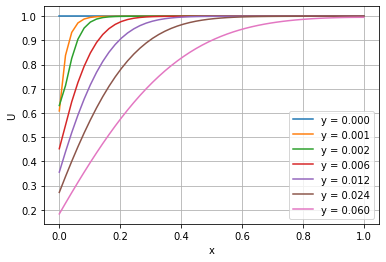

In [136]:
plt.xlabel('x'); plt.ylabel('U')
times = np.array([0., 0.1, 0.2, 0.5, 1., 2., 5.])  # h
timeIndeces = (times*3600/tScale*Ny + 0.5).astype(int)
# timeIndeces = np.array([1, 2, 5, 10, 30, 100]) - 1
print(timeIndeces)
for timeIndex in timeIndeces:
    plt.plot(x_grid, USoln[timeIndex], label='y = '+'{:.3f}'.format(timeIndex*dy))
# plt.xlim(0, 0.1)
plt.legend()
plt.grid()
plt.show()

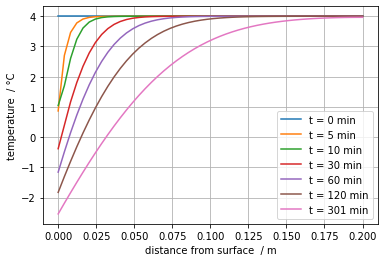

In [137]:
plt.xlabel('distance from surface  / m'); plt.ylabel('temperature  / °C')
for timeIndex in timeIndeces:
    plt.plot(x_grid*LScale, USoln[timeIndex]*(T0-TAmb)+TAmb, label='t = '+'{:.0f}'.format(timeIndex/Ny*tScale/60)+' min')
# plt.xlim(0, 0.1)
plt.legend()
plt.grid()
# plt.show()

plt.savefig('last cooling of water')

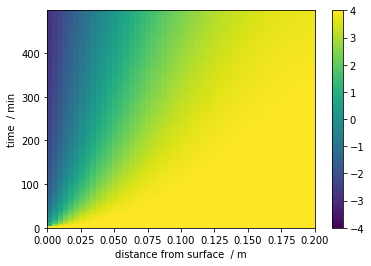

In [138]:
fig, ax = plt.subplots()
plt.xlabel('distance from surface  / m'); plt.ylabel('time  / min')
heatmap = ax.pcolormesh(x_grid*LScale, y_grid[:100]*tChar/60, USoln[:100]*(T0-TAmb)+TAmb, vmin=TAmb, vmax=T0)
fig.colorbar(heatmap, ax=ax)

In [ ]:
Function LSU_242(x, t, T0, q, a, k, cp, rho, n)
  Pi = 355 / 113
  tau = k * t / (cp * rho)
  Sum = 0
  For i = 0 To n
    ii = 2 * i + 1
    Sum = Sum + (q / k + (-1) ^ i * ii / (2 * a) * Pi * T0) * Exp(-ii ^ 2 * Pi ^ 2 * tau / (4 * a ^ 2)) * Cos(ii * Pi * x / (2 * a)) / ii ^ 2
  Next i
  LSU_242 = T0 + q * a / k * (1 - x / a) - 8 * a / Pi ^ 2 * Sum
End Function

https://georg.io/2013/12/03/Crank_Nicolson

In [4]:
# specify grid

# in space
L = 1.
J = 100
dx = float(L)/float(J-1)
x_grid = numpy.array([j*dx for j in range(J)])

# in time
T = 200
N = 1000
dt = float(T)/float(N-1)
t_grid = numpy.array([n*dt for n in range(N)])

In [5]:
# parameters
D_v = float(10.)/float(100.)
D_u = 0.01 * D_v

k0 = 0.067
f = lambda u, v: dt*(v*(k0 + float(u*u)/float(1. + u*u)) - u)
g = lambda u, v: -f(u,v)
 
sigma_u = float(D_u*dt)/float((2.*dx*dx))
sigma_v = float(D_v*dt)/float((2.*dx*dx))

total_protein = 2.26

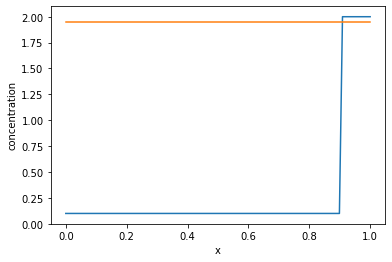

In [10]:
# initial condition
no_high = 10
U =  numpy.array([0.1 for i in range(no_high,J)] + [2. for i in range(0,no_high)])
V = numpy.array([float(total_protein-dx*sum(U))/float(J*dx) for i in range(0,J)])

pyplot.ylim((0., 2.1))
pyplot.xlabel('x'); pyplot.ylabel('concentration')
pyplot.plot(x_grid, U)
pyplot.plot(x_grid, V)
pyplot.show()

In [11]:
# set up matrices
A_u = numpy.diagflat([-sigma_u for i in range(J-1)], -1) +\
      numpy.diagflat([1.+sigma_u]+[1.+2.*sigma_u for i in range(J-2)]+[1.+sigma_u]) +\
      numpy.diagflat([-sigma_u for i in range(J-1)], 1)
        
B_u = numpy.diagflat([sigma_u for i in range(J-1)], -1) +\
      numpy.diagflat([1.-sigma_u]+[1.-2.*sigma_u for i in range(J-2)]+[1.-sigma_u]) +\
      numpy.diagflat([sigma_u for i in range(J-1)], 1)
        
A_v = numpy.diagflat([-sigma_v for i in range(J-1)], -1) +\
      numpy.diagflat([1.+sigma_v]+[1.+2.*sigma_v for i in range(J-2)]+[1.+sigma_v]) +\
      numpy.diagflat([-sigma_v for i in range(J-1)], 1)
        
B_v = numpy.diagflat([sigma_v for i in range(J-1)], -1) +\
      numpy.diagflat([1.-sigma_v]+[1.-2.*sigma_v for i in range(J-2)]+[1.-sigma_v]) +\
      numpy.diagflat([sigma_v for i in range(J-1)], 1)

A_u

array([[ 1.981, -0.981,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [-0.981,  2.962, -0.981, ...,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.981,  2.962, ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.   ,  0.   ,  0.   , ...,  2.962, -0.981,  0.   ],
       [ 0.   ,  0.   ,  0.   , ..., -0.981,  2.962, -0.981],
       [ 0.   ,  0.   ,  0.   , ...,  0.   , -0.981,  1.981]])

In [12]:
# solve
f_vec = lambda U, V: numpy.multiply(dt, numpy.subtract(numpy.multiply(V, 
                     numpy.add(k0, numpy.divide(numpy.multiply(U,U), numpy.add(1., numpy.multiply(U,U))))), U))

In [13]:
f(U[0], V[0])

0.009961358982745121

In [14]:
f(U[-1], V[-1])

-0.06238322322322325

In [15]:
f_vec(U, V)

array([ 0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,
        0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,
        0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,
        0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,
        0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,
        0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,
        0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,
        0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,
        0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,
        0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,
        0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,  0.01 ,
        0.01 ,  0.01 , -0.062, -0.062, -0.062, -0.062, -0.062, -0.062,
       -0.062, -0.062, -0.062, -0.062])

In [16]:
U_record = []
V_record = []

U_record.append(U)
V_record.append(V)

for ti in range(1,N):
    U_new = numpy.linalg.solve(A_u, B_u.dot(U) + f_vec(U,V))
    V_new = numpy.linalg.solve(A_v, B_v.dot(V) - f_vec(U,V))
    
    U = U_new
    V = V_new
    
    U_record.append(U)
    V_record.append(V)

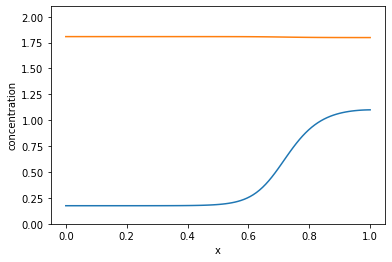

In [17]:
pyplot.ylim((0., 2.1))
pyplot.xlabel('x'); pyplot.ylabel('concentration')
pyplot.plot(x_grid, U)
pyplot.plot(x_grid, V)
pyplot.show()

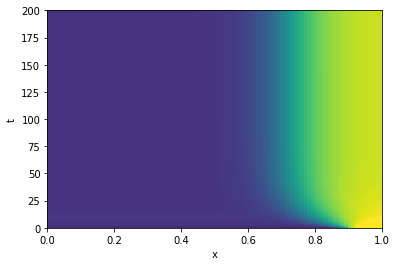

In [18]:
U_record = numpy.array(U_record)
V_record = numpy.array(V_record)

fig, ax = pyplot.subplots()
pyplot.xlabel('x'); pyplot.ylabel('t')
heatmap = ax.pcolor(x_grid, t_grid, U_record, vmin=0., vmax=1.2)

## The transient solution
We use the Crank--Nicolson scheme

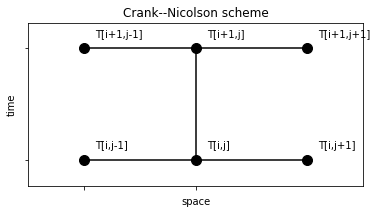

In [9]:
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg' # display plots in SVG format
 
plt.figure(figsize=(6,3))
plt.plot([0,2],[0,0],'k')
plt.plot([0,2],[1,1],'k')
plt.plot([1,1],[0,1],'k')
plt.plot([0,1,2,0,1,2],[0,0,0,1,1,1],'ko',markersize=10)
plt.text(0.1,0.1,'T[i,j-1]')
plt.text(1.1,0.1,'T[i,j]')
plt.text(2.1,0.1,'T[i,j+1]')
plt.text(0.1,1.1,'T[i+1,j-1]')
plt.text(1.1,1.1,'T[i+1,j]')
plt.text(2.1,1.1,'T[i+1,j+1]')
plt.xlabel('space')
plt.ylabel('time')
plt.axis('equal')
plt.yticks([0.0,1.0],[])
plt.xticks([0.0,1.0],[])
plt.title('Crank--Nicolson scheme',fontsize=12)
plt.axis([-0.5,2.5,-0.5,1.5]);

In [23]:
# Numerics
DT_ss = 0.2  # K, criterion for reaching steady-state

Du1_ss = DT_ss/(T_b1 - T_a)
Du2_ss = DT_ss/(T_b2 - T_b1)
print(Du1_ss, Du2_ss)

ZeroDivisionError: float division by zero

In [10]:
def u_CN(dx, nx, dy, ny, u, D_s, D_f, betaPrime_s, betaPrime_f, Du, nyout):
    beta_s = 0.5*betaPrime_s*dy
    beta_f = 0.5*betaPrime_f*dy
    gamma_s = 0.5*D_s*dy/dx**2
    gamma_f = 0.5*D_f*dy/dx**2
    
    BB = mySensor.BB
    Bi_w = mySensor.Bi_w
    Bi_i = mySensor.Bi_i
 
    # assemble matrices A_kl and B_kl (without applying BCs)
    A_ss = diags([-gamma_s, 1+2*gamma_s+beta_s*(1+BB), -gamma_s], [-1, 0,1], shape = (nx, nx)).toarray()
    A_sf = diags([-beta_s*BB], [0], shape = (nx, nx)).toarray()
    A_fs = diags([-beta_f], [0], shape = (nx, nx)).toarray()
    A_ff = diags([-gamma_f, 1+2*gamma_f+beta_f, -gamma_f], [-1, 0, 1], shape = (nx, nx)).toarray()
    B_ss = diags([gamma_s, 1-2*gamma_s-beta_s*(1+BB), gamma_s], [-1, 0,1], shape = (nx, nx)).toarray()
    B_sf = diags([beta_s*BB], [0], shape = (nx, nx)).toarray()
    B_fs = diags([beta_f], [0], shape = (nx, nx)).toarray()
    B_ff = diags([gamma_f, 1-2*gamma_f-beta_f, gamma_f], [-1, 0, 1], shape = (nx, nx)).toarray()
    
    # apply BCs in A_kl and B_kl
    A_ss[0,0] = 1+2*(1+Bi_w*dx)*gamma_s+beta_s*(1+BB)
    A_ss[0,1] = -2*gamma_s
    A_ss[nx-1,nx-2] = -2*gamma_s
    A_ff[0,0] = 1+2*(1+Bi_i*dx)*gamma_f+beta_f
    A_ff[0,1] = -2*gamma_f
    A_ff[nx-1,nx-2] = -2*gamma_f
    B_ss[0,0] = 1-2*(1+Bi_w*dx)*gamma_s-beta_s*(1+BB)
    B_ss[0,1] = 2*gamma_s
    B_ss[nx-1,nx-2] = 2*gamma_s
    B_ff[0,0] = 1-2*(1+Bi_i*dx)*gamma_f-beta_s
    B_ff[0,1] = 2*gamma_f
    B_ff[nx-1,nx-2] = 2*gamma_f
    
    # assemble the BC vectors b_k
    b_s = np.zeros(nx)
    b_s[0] = 4*Bi_w*dx*gamma_s
    b_f = np.zeros(nx)
    b_f[0] = 4*Bi_i*dx*gamma_f
    
    # assemble A, B, and b
    A_s = np.concatenate((A_ss, A_sf), axis = 1)
    A_f = np.concatenate((A_fs, A_ff), axis = 1)
    A = np.concatenate((A_s, A_f))
    B_s = np.concatenate((B_ss, B_sf), axis = 1)
    B_f = np.concatenate((B_fs, B_ff), axis = 1)
    B = np.concatenate((B_s, B_f))
    b = np.concatenate((b_s, b_f))
    
    u_sout = np.zeros(shape = (nyout, nx))
    u_fout = np.zeros(shape = (nyout, nx))
    i_out = 0
    i_ss = 0
    for i in range(1, ny):
        u_i = u
        Bu_i = np.dot(B, u_i) 
        u = np.linalg.solve(A, Bu_i+b)
        if (u[-1] >= (u_fss[-1]-Du)) and (i_ss == 0):
            print(i, u[-1], u_fss[-1])
            i_ss = i
        if i in yout:
            u_sout[i_out] = u[:nx]
            u_fout[i_out] = u[nx:]
            i_out = i_out + 1
    return u_sout, u_fout, i_ss

In [11]:
dy = 0.001 # grid size for time (---)
dx = 0.02 # grid size for space (---)
x_max = 1
x = np.arange(0, x_max+dx, dx) 
nx = len(x)
ny = 7200
ncurve = 3
yout = [0]*ncurve
for k in range(ncurve):
    yout[k] = int(10**(math.log10(ny)/(k+1))) - 1
print(yout)
    
D_s = 1
D_f = mySensor.c*mySensor.r
betaPrime_s = mySensor.Bi_a*mySensor.p_a*mySensor.L2
betaPrime_f = mySensor.Bi_f*mySensor.p_f*mySensor.L2*mySensor.a*mySensor.c

[7199, 83, 18]


Text(0.5, 1.0, 'From u_a')

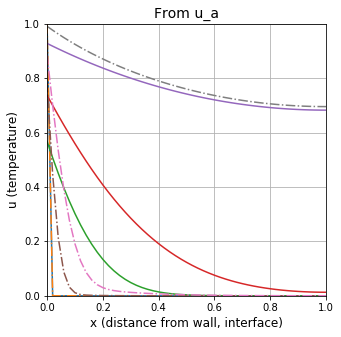

In [12]:
# Going from u_a to steady-state for u_b1
u_s0 = np.zeros((nx, )) # initial condition
u_s0[0] = 1
u_f0 = np.zeros((nx, )) # initial condition
u_f0[0] = 1
u0 = np.concatenate((u_s0, u_f0))
plt.figure(figsize = (5, 5))
plt.plot(x, u_s0)
plt.plot(x, u_f0, "-.")

u_sout, u_fout, i1_fin = u_CN(dx, nx, dy, ny, u0, D_s, D_f, betaPrime_s, betaPrime_f, Du1_ss, ncurve)

u_plt = np.zeros(nx)
for u_plt in u_sout:
    plt.plot(x, u_plt)
for u_plt in u_fout:
    plt.plot(x, u_plt, "-.")
    
plt.xlabel('x (distance from wall, interface)', fontsize = 12)
plt.ylabel('u (temperature)', fontsize = 12)
plt.axis([0, 1, 0, 1])
plt.grid()
plt.title('From u_a', fontsize = 14)

2755 0.684780199679127 0.7047762137066779


Text(0.5, 1.0, 'From u_ss')

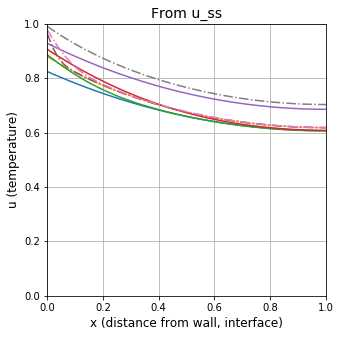

In [13]:
# Going from steady-state for u_b1 to steady-state for u_b2
u_s0 = u_sout[-1,:]*(T_b1 - T_a)/(T_b2 - T_a)
u_f0 = u_fout[-1,:]*(T_b1 - T_a)/(T_b2 - T_a)
u0 = np.concatenate((u_s0, u_f0))
plt.figure(figsize = (5, 5))
plt.plot(x, u_s0)
plt.plot(x, u_f0, "-.")

u_sout, u_fout, i2_fin = u_CN(dx, nx, dy, ny, u0, D_s, D_f, betaPrime_s, betaPrime_f, Du2_ss, ncurve)

u_plt = np.zeros(nx)
for u_plt in u_sout:
    plt.plot(x, u_plt)
for u_plt in u_fout:
    plt.plot(x, u_plt, "-.")
    
plt.xlabel('x (distance from wall, interface)', fontsize = 12)
plt.ylabel('u (temperature)', fontsize = 12)
plt.axis([0, 1, 0, 1])
plt.grid()
plt.title('From u_ss', fontsize = 14)

0 2755
Time 1 to steady-state (within  0.2) K:     0 s =   0 min
Time 2 to steady-state (within  0.2) K:  1810 s =  30 min


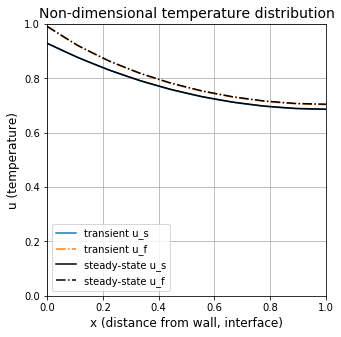

In [14]:
print(i1_fin, i2_fin)
t_ss = i1_fin*dy*mySensor.tau
print("Time 1 to steady-state (within {a: 2.1f}) K: {b: 5.0f} s = {c: 3.0f} min".format(a = DT_ss, b = t_ss, c = t_ss/60))
t_ss = i2_fin*dy*mySensor.tau
print("Time 2 to steady-state (within {a: 2.1f}) K: {b: 5.0f} s = {c: 3.0f} min".format(a = DT_ss, b = t_ss, c = t_ss/60))

plt.figure(figsize = (5, 5))
plt.plot(x, u_sout[-1,:], label='transient u_s')
plt.plot(x, u_fout[-1,:], "-.", label='transient u_f')
plt.plot(xs, u_sss, "k", label='steady-state u_s')
plt.plot(xs, u_fss, "k-.", label='steady-state u_f')
plt.xlabel('x (distance from wall, interface)', fontsize = 12)
plt.ylabel('u (temperature)', fontsize = 12)
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend()
plt.title('Non-dimensional temperature distribution', fontsize = 14);